# Data Inspection & Preparation

## connect with google drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/Colab Notebooks/github/' # specify your working directory here
print(os.listdir(cwd))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['MIL data', 'MIL models', 'py_scripts', 'data_input_milldi.json', 'README_temp.txt', 'Controller_MILPS.ipynb', 'README_temp.gdoc', 'Data_preprocessing.ipynb']


## load raw data

In [ ]:
import json
with open(cwd+'MIL data/data_input_milldi.json', 'r') as f:
  data_raw = json.load(f)

##inspect raw data

In [ ]:
print(f"number of keys:{len(data_raw.keys())}")
print("example element:")
for k,v in data_raw.items():
  if len(v['sentiments'])>1:
    break
print(k)
print(v.keys())
print(v['tokens'])
print(v['rating review'])
for sentiment in v['sentiments']:
  for k_s,v_s in sentiment.items():
    print(str(k_s)+': '+str(v_s))

number of keys:10502
example element:
98497_16
dict_keys(['sentiments', 'tokens', 'labeled with C', 'id review', 'rating review'])
['Loved', 'the', 'meat', ',', 'but', 'could', 'pass', 'on', 'the', 'noodles', 'it', 'comes', 'with', '.']
4
sentiment score: 2
idx sentiment term: [0]
tokens sentiment term: ['Loved']
modifier: {}
sentiment targets: [{'idx sentiment target': [2], 'tokens sentiment target': ['meat'], 'category': 'f'}]
category: f
sentiment score: -1
idx sentiment term: [5, 6]
tokens sentiment term: ['could', 'pass']
modifier: {}
sentiment targets: [{'idx sentiment target': [9], 'tokens sentiment target': ['noodles'], 'category': 'f'}]
category: f


In [ ]:
for k,v in data_raw.items():
  if len(v['sentiments'])>1:
    break
print(k)
print(type(v))
print(v)
scores = list()
for sentiment in v['sentiments']:
  scores.append(sentiment['sentiment score'])
import numpy as np
print(scores,np.mean(scores))

98497_16
<class 'dict'>
{'sentiments': [{'sentiment score': 2, 'idx sentiment term': [0], 'tokens sentiment term': ['Loved'], 'modifier': {}, 'sentiment targets': [{'idx sentiment target': [2], 'tokens sentiment target': ['meat'], 'category': 'f'}], 'category': 'f'}, {'sentiment score': -1, 'idx sentiment term': [5, 6], 'tokens sentiment term': ['could', 'pass'], 'modifier': {}, 'sentiment targets': [{'idx sentiment target': [9], 'tokens sentiment target': ['noodles'], 'category': 'f'}], 'category': 'f'}], 'tokens': ['Loved', 'the', 'meat', ',', 'but', 'could', 'pass', 'on', 'the', 'noodles', 'it', 'comes', 'with', '.'], 'labeled with C': False, 'id review': 98497, 'rating review': 4}
[2, -1] 0.5


In [ ]:
senti_scores = []
temp_id = ''
for k,v in data_raw.items():
  if 'sentiments' in v.keys():
    senti_temp = list()
    for sentiment in v['sentiments']:
      senti_temp.append(sentiment['sentiment score'])
      senti_scores.append(sentiment['sentiment score'])
    if len(senti_temp) == 1 and np.mean(senti_temp)<-1:
      temp_id = k
print(min(senti_scores),max(senti_scores))
print(temp_id)
print(data_raw[temp_id]['sentiments'])

-2 2
123444_6
[{'sentiment score': -2, 'idx sentiment term': [24, 25], 'tokens sentiment term': ['helpful', 'mood'], 'modifier': {}, 'sentiment targets': [], 'category': 's'}]


## tokenize reviews and sentences

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 3.5 MB 6.7 MB/s 
     |████████████████████████████████| 895 kB 63.2 MB/s 
     |████████████████████████████████| 67 kB 7.8 MB/s 
     |████████████████████████████████| 596 kB 62.8 MB/s 
     |████████████████████████████████| 6.5 MB 61.6 MB/s 


In [ ]:
from transformers import BertTokenizer
# BERT Tokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### inspect BERT tokenizer

In [ ]:
sample_txt= 'i am very knowledgeable'
tokens_other_tokenizer = sample_txt.split()
tokens = tokenizer.tokenize(sample_txt) # utilizes wordpiece tokenizer -> knowledgeable -> 'knowledgeable', '##able'
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids_other_tokenizer = tokenizer.convert_tokens_to_ids(tokens_other_tokenizer)


print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')
print(f'   Tokens: {tokens_other_tokenizer}')
print(f'Token IDs: {token_ids_other_tokenizer}') # bert does not know knowledgeable !!!

 Sentence: i am very knowledgeable
   Tokens: ['i', 'am', 'very', 'knowledge', '##able']
Token IDs: [178, 1821, 1304, 3044, 1895]
   Tokens: ['i', 'am', 'very', 'knowledgeable']
Token IDs: [178, 1821, 1304, 100]


In [ ]:
tokenizer.sep_token_id, tokenizer.cls_token_id, tokenizer.unk_token_id, tokenizer.pad_token_id

(102, 101, 100, 0)

In [ ]:
# trying the functions of tokenizer (BertTokenizer.from_pretrained)
tokens = ['this','is','a', 'knowledgeable','test']
print(tokenizer(tokens,tokens, is_split_into_words=True,padding='max_length',max_length = 30))
print(tokenizer(' '.join(tokens)))
bert_encoded = tokenizer(tokens,#tokens,
                      is_split_into_words=True,
                      padding='max_length',
                      truncation=True,
                      return_tensors="pt",max_length= 30,
                      return_attention_mask=True)
print(bert_encoded.keys())
print(bert_encoded)
print(bert_encoded['input_ids'].size())
print(bert_encoded['input_ids'].flatten().size())



{'input_ids': [101, 1142, 1110, 170, 3044, 1895, 2774, 102, 1142, 1110, 170, 3044, 1895, 2774, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'input_ids': [101, 1142, 1110, 170, 3044, 1895, 2774, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
{'input_ids': tensor([[ 101, 1142, 1110,  170, 3044, 1895, 2774,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

#### tokenize sentences

In [ ]:
tokens_pretokenized = [v['tokens'] for v in data_raw.values()]
print(tokens_pretokenized[:3])
tokens = tokenizer(tokens_pretokenized, is_split_into_words=True)
print(tokens.keys())
for v in tokens.values():
  print(v[:2])
token_lens = [len(i) for i in tokens['input_ids']]
print(len(token_lens))

[['1', ')', 'P', '.', 'E', '.', 'I', '.'], ['Mussels', '-', 'So', 'much', 'flavor', '!'], ['I', 'was', 'literally', 'licking', 'the', 'sauce', 'off', 'my', 'plate', '.']]
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[[101, 122, 114, 153, 119, 142, 119, 146, 119, 102], [101, 19569, 16077, 1116, 118, 1573, 1277, 16852, 106, 102]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
10502


##choose max sequence length

In [ ]:
!pip install -q seaborn
import seaborn as sns

In [ ]:
!pip install -q matplotlib
from matplotlib import pyplot as plt

### for sentences

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


longest sequence has length 178
longer than 60: 0.9998095600837935 %


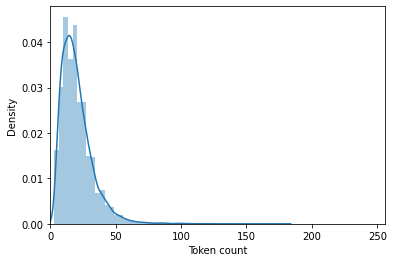

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
print(f"longest sequence has length {max(token_lens)}")
max_seq_len_sentc = 60
print(f"longer than {max_seq_len_sentc}: {len([t for t in token_lens if t > max_seq_len_sentc])/len(token_lens)*100} %")

### for reviews

In [ ]:
revid_2_sentcid_2_data_raw = dict()
for k,v in data_raw.items():
  revid,sentcid = k.split('_')
  sentcid_2_data_raw = revid_2_sentcid_2_data_raw.setdefault(revid,dict())
  sentcid_2_data_raw[sentcid] = v

print(f"number of reviews = {len(revid_2_sentcid_2_data_raw.keys())}")
import numpy as np
revid_2_number_sentc = dict([(k,len(v.keys())) for k,v in revid_2_sentcid_2_data_raw.items()])
print(f"avg sentences in review = {np.mean(list(revid_2_number_sentc.values()))}")

number of reviews = 1266
avg sentences in review = 8.295418641390205


62
longest sequence has length 62
longer than 35: 0.9478672985781991 %


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


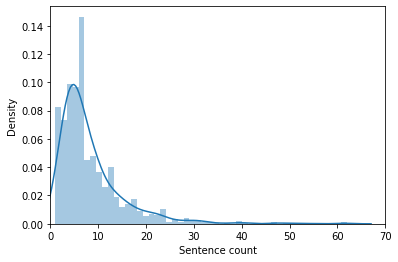

In [ ]:
sentc_lens = list(revid_2_number_sentc.values())
print(max(sentc_lens))
sns.distplot(sentc_lens)
plt.xlim([0, 70]);
plt.xlabel('Sentence count');
print(f"longest sequence has length {max(sentc_lens)}")
max_seq_len_rev = 35
print(f"longer than {max_seq_len_rev}: {len([t for t in sentc_lens if t > max_seq_len_rev])/len(sentc_lens)*100} %")

# Dataset & Dataloader

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# recap inspection of raw dataset
for revid,v in revid_2_sentcid_2_data_raw.items():
  exit_flag = False
  for sentcid,vv in v.items():
    if vv['sentiments']:
      exit_flag = True
      break
  if exit_flag: break
print(revid,type(revid))
print(sentcid,type(sentcid))
print(f'start id sentences: {min([int(i) for i in v.keys()])}')
print(f'number of sentences: {len(v.keys())}')
print(vv.keys())
print(vv['tokens'])
print(vv['rating review'])
for sentiment in vv['sentiments']:
  for k_s,v_s in sentiment.items():
    print(str(k_s)+': '+str(v_s))
  print('type of sentiment score: '+str(type(sentiment['sentiment score'])))

98497 <class 'str'>
5 <class 'str'>
start id sentences: 1
number of sentences: 31
dict_keys(['sentiments', 'tokens', 'labeled with C', 'id review', 'rating review'])
['Mussels', '-', 'So', 'much', 'flavor', '!']
4
sentiment score: 2
idx sentiment term: [2, 3, 4]
tokens sentiment term: ['So', 'much', 'flavor']
modifier: {'2': ['STR']}
sentiment targets: [{'idx sentiment target': [0], 'tokens sentiment target': ['Mussels'], 'category': 'f'}]
category: f
type of sentiment score: <class 'int'>


In [ ]:
# playground cell
print(type(tokenizer))
print(type(float(0)))
print(np.mean([1]))
assert 1 == 1.0
tokens = ['']
bert_encoded = tokenizer(tokens,
                      is_split_into_words=True,
                      padding='max_length',
                      truncation=True,
                      return_token_type_ids=False,
                      return_attention_mask=True,
                      return_tensors="pt",max_length= 10)
print(bert_encoded) # CLS, SEP, PAD, PAD, ...

<class 'transformers.models.bert.tokenization_bert.BertTokenizer'>
<class 'float'>
1.0
{'input_ids': tensor([[101, 102,   0,   0,   0,   0,   0,   0,   0,   0]]), 'attention_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


## import class MILRestsDataset

In [ ]:
# import dataset class from MIL_nn_utils
from torch.utils.data import Dataset
import sys
if cwd+'py_scripts/' not in sys.path:
  sys.path.append(cwd+'py_scripts/')
if "MIL_nn_utils" in sys.modules.keys():
  del sys.modules['MIL_nn_utils']
from MIL_nn_utils import MILRestsDataset

## create dataset for train, dev, test data

In [ ]:
# define method for train test splits
def mil_train_test_split(revid_2_sentcid_2_data_raw, test_size,random_state):
  data_train,data_test = dict(),dict()
  ids_rev = list(set([i.split('_')[0] for i in revid_2_sentcid_2_data_raw.keys()]))
  import random
  random.seed(random_state)
  random.shuffle(ids_rev)
  n = len(ids_rev)
  ids_rev_test = ids_rev[:round(n*test_size)]
  for id_rev,v in revid_2_sentcid_2_data_raw.items():
    if id_rev in ids_rev_test:
      data_test[id_rev]=v
    else:
      data_train[id_rev]=v
  return data_train,data_test

In [ ]:
RANDOM_SEED = 1234
data_train_raw, data_test_raw = mil_train_test_split(revid_2_sentcid_2_data_raw, test_size=0.30, random_state=RANDOM_SEED)
data_dev_raw, data_test_raw = mil_train_test_split(data_test_raw, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
max_seq_len_rev = 35
max_seq_len_sentc = 60
data_train = MILRestsDataset(data_train_raw,tokenizer,max_seq_len_rev, max_seq_len_sentc)
data_dev = MILRestsDataset(data_dev_raw,tokenizer,max_seq_len_rev, max_seq_len_sentc)
data_test = MILRestsDataset(data_test_raw,tokenizer,max_seq_len_rev, max_seq_len_sentc)

In [ ]:
print(len(data_train))
c_s_train = 0
for r in data_train:
  break
print(r.keys())
print(r['id_sentc_list'])
for i in r['id_sentc_list']:
  if int(i)<0:break
print(len(data_dev))
print(len(data_test))

886
dict_keys(['id_rev', 'rating_rev', 'id_sentc_list', 'senti_sentc_tensor', 'tokenids_sentc_tensor', 'attmasks_sentc_tensor'])
['1', '2', '3', '4', '5', '-6', '-7', '-8', '-9', '-10', '-11', '-12', '-13', '-14', '-15', '-16', '-17', '-18', '-19', '-20', '-21', '-22', '-23', '-24', '-25', '-26', '-27', '-28', '-29', '-30', '-31', '-32', '-33', '-34', '-35']
190
190


## save data_train, data_dev, data_test

In [ ]:
from os.path import exists
file_directory = cwd+'MIL data/'
train_file_exists = exists(file_directory+'data_train_0.7.bin')
if not train_file_exists:
  import torch
  torch.save(data_train,file_directory+'data_train_0.7.bin')
  torch.save(data_dev,file_directory+'data_dev_0.15.bin')
  torch.save(data_test,file_directory+'data_test_0.15.bin')

True


## create dataloader for train, dev, test data

In [ ]:
# load data
data_train=torch.load(file_directory+'data_train_0.7.bin')
data_dev=torch.load(file_directory+'data_dev_0.15.bin')
data_test=torch.load(file_directory+'data_test_0.15.bin')

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16
train_dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(data_dev, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

## verify that dataset and dataloader works fine


In [ ]:
if True:
  # check out an example sentence
  rev_id_debug = '123444'
  sentc_id_debug = '6'
  print(data_raw['123444_6']['sentiments'][0])
  print(rev_id_debug in data_train_raw.keys())
  print(rev_id_debug in data_dev_raw.keys())
  print(rev_id_debug in data_test_raw.keys())
  print(type(data_test_raw[rev_id_debug]))
  print(data_test_raw[rev_id_debug].keys())
  print(data_test_raw[rev_id_debug]['6']['sentiments'])
  for row in test_dataloader:
    if rev_id_debug in row['id_rev']:
      break
  print(row.keys())
  print(row['id_rev'][2])
  print(row['senti_sentc_tensor'][2])
  print(row['id_sentc_list'][5][2])
  print(row['rating_rev'][2])

{'sentiment score': -2, 'idx sentiment term': [24, 25], 'tokens sentiment term': ['helpful', 'mood'], 'modifier': {}, 'sentiment targets': [], 'category': 's'}
False
False
True
<class 'dict'>
dict_keys(['1', '7', '8', '11', '13', '14', '17', '16', '15', '5', '9', '2', '12', '4', '3', '10', '6'])
[{'sentiment score': -2, 'idx sentiment term': [24, 25], 'tokens sentiment term': ['helpful', 'mood'], 'modifier': {}, 'sentiment targets': [], 'category': 's'}]
dict_keys(['id_rev', 'rating_rev', 'id_sentc_list', 'senti_sentc_tensor', 'tokenids_sentc_tensor', 'attmasks_sentc_tensor'])
579648
tensor([ 1,  1, -1, -1, -1, -2,  0,  1,  0,  0, -1,  0, -2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
6
tensor(1)


In [ ]:
## verify that dataset and dataloader works fine
# basic stats
if True:
  print(f'len of data_train: {len(data_train)}')
  print(data_train.ids_rev)
  print(f'len of train_dataloader: {len(train_dataloader)}')
  # Display an example item / batch
if True:
  batch = next(iter(train_dataloader))
  for k,v in batch.items():
    print(k, type(v))
  print('id_rev')
  print(len(batch['id_rev']))
  print(batch['id_rev'][0])
  print('rating_rev')
  print(batch['rating_rev'].shape)
  print(batch['rating_rev'][0])

  print('id_sentc_list')
  print(len(batch['id_sentc_list']))
  print(len(batch['id_sentc_list'][0]))
  print(batch['id_sentc_list'][0][0])

  print('senti_sentc_tensor')
  print(batch['senti_sentc_tensor'].shape)
  print(batch['senti_sentc_tensor'][0])

  print('tokenids_sentc_tensor')
  print(batch['tokenids_sentc_tensor'].shape)
  print(batch['tokenids_sentc_tensor'][0].shape)
  print(batch['tokenids_sentc_tensor'][0][0])

  print('attmasks_sentc_tensor')
  print(batch['attmasks_sentc_tensor'].shape)
  print(batch['attmasks_sentc_tensor'][0].shape)
  print(batch['attmasks_sentc_tensor'][0][0])

len of data_train: 886
['1479129', '1210392', '725270', '189565', '218156', '1286953', '862772', '1761065', '1388731', '106626', '567486', '1808909', '2069403', '2152901', '1406489', '713813', '1770244', '1738266', '1898513', '1231719', '755484', '1937471', '1466156', '1686236', '1634550', '361213', '1208108', '1337535', '1972229', '871140', '1714023', '1105874', '1828955', '166642', '1237874', '19032', '395166', '393272', '2027405', '1568085', '2119416', '1305429', '1345204', '212289', '285717', '2316572', '1158283', '1390823', '2065849', '2246348', '401732', '703211', '600403', '1153929', '542000', '352935', '385906', '1259886', '1340304', '1104111', '323151', '1624334', '285810', '1302235', '1722505', '1306986', '104799', '1384145', '490944', '351552', '1537653', '1569535', '1378275', '448057', '1223848', '1236719', '1173043', '327951', '1870502', '1594109', '2059674', '2111971', '581060', '1724402', '1067180', '1620319', '1892189', '859442', '1637788', '1494853', '782269', '628228'